# Métricas e cross-validation

Até então, vimos como criar modelos de séries temporais e avaliamos qualitativamente seu desempenho, em apenas uma simples divisão treino-teste. Agora, vamos explorar como avaliar modelos de séries temporais de forma mais robusta, utilizando métricas específicas e técnicas de validação cruzada adaptadas para dados temporais.



## Métricas

Primeiro vamos baixar os dados e criar um modelo simples.


In [1]:
import matplotlib.pyplot as plt
from tsbook.datasets.retail import SyntheticRetail
from sktime.utils.plotting import plot_series
from sktime.forecasting.naive import NaiveForecaster

dataset = SyntheticRetail("univariate")
y_train, y_test = dataset.load("y_train", "y_test")

# Predict
model = NaiveForecaster(strategy="last")
model.fit(y_train)
y_pred = model.predict(fh=y_test.index)

Para avaliar o desempenho de modelos de séries temporais, existem diversas métricas que podem ser utilizadas. 

Duas métricas básicas são:

* **Mean Absolute Error (MAE)**: Média dos erros absolutos entre as previsões e os valores reais.
$$
MAE = \frac{1}{h} \sum_{t=T+1}^{T+h} |y_t - \hat{y}_t|
$$

In [2]:
from sktime.performance_metrics.forecasting import MeanAbsoluteError

metric = MeanAbsoluteError()
metric(y_true=y_test, y_pred=y_pred)

np.float64(615.0555555555555)

* **Mean Squared Error (MSE)**: Média dos erros quadráticos entre as previsões e os valores reais.

$$
MSE = \frac{1}{h} \sum_{t=T+1}^{T+h} (y_t - \hat{y}_t)^2
$$

In [3]:
from sktime.performance_metrics.forecasting import MeanSquaredError

metric = MeanSquaredError()
metric(y_true=y_test, y_pred=y_pred)

np.float64(633773.8777777777)

No entanto, essas métricas não levam em consideração a escala dos dados, o que pode ser um problema ao comparar desempenho entre diferentes séries temporais, e também na comunicação dos resultados para stakeholders.

Em muitos meios, é comum usar métricas que eliminam o fator escala, como:

* **Mean Absolute Percentage Error (MAPE)**: Média dos erros percentuais absolutos entre as previsões e os valores reais.

$$
MAPE = \frac{1}{h} \sum_{t=T+1}^{T+h} \left| \frac{y_t - \hat{y}_t}{y_t} \right|
$$


In [4]:
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError

metric = MeanAbsolutePercentageError()
metric(y_true=y_test, y_pred=y_pred)

np.float64(0.21292470853237802)

* **Symmetric Mean Absolute Percentage Error (sMAPE)**: Média dos erros percentuais absolutos simétricos entre as previsões e os valores reais.

In [5]:
metric = MeanAbsolutePercentageError(symmetric=True)
metric(y_true=y_test, y_pred=y_pred)

np.float64(0.22359840490570626)

$$
sMAPE = \frac{1}{h} \sum_{t=T+1}^{T+h} \frac{|y_t - \hat{y}_t|}{(|y_t| + |\hat{y}_t|)/2}
$$

Essas métricas, no entanto, apresentam seus próprios problemas. Note que os valores
podem ser exageradamente alto quando o denominador é próximo de zero. Ou seja, o MAPE e sMAPE podem ser problemáticos quando a série temporal contém valores próximos de zero.

Outro tema é que essas métricas não consideram a dificuldade da série. Por exemplo, 5% de erro pode ser muito em uma série, e pouco em outra. Para isso, foram propostas métricas "escalas":

* **Mean Absolute Scaled Error (MASE)**: dividimos o erro absoluto pelo erro absoluto médio de um naive nos dados de treino. Se:

$$
e_{naive} = \frac{1}{T-1} \sum_{t=2}^{T} |y_t - y_{t-1}|
$$

são os erros nos dados de treino, então:

$$
MASE = \frac{1}{h} \sum_{t=T+1}^{T+h} \frac{|y_t - \hat{y}_t|}{e_{naive}}
$$


In [6]:
from sktime.performance_metrics.forecasting import MeanAbsoluteScaledError

metric = MeanAbsoluteScaledError()
metric(y_true=y_test, y_pred=y_pred, y_train=y_train)

np.float64(10.127736897882464)

* **Mean Squared Scaled Error (MSSE)**: dividimos o erro quadrático pelo quadrado de $e_{naive}$.

$$
MSSE = \frac{1}{h} \sum_{t=T+1}^{T+h} \frac{(y_t - \hat{y}_t)^2}{e_{naive}^2}
$$

In [7]:
from sktime.performance_metrics.forecasting import MeanSquaredScaledError

metric = MeanSquaredScaledError()
metric(y_true=y_test, y_pred=y_pred, y_train=y_train)

np.float64(57.09087480132447)

## Cross-validation para séries temporais

Em um cross-validation, nossa intenção é estimar corretamente o erro de generalização do modelo, ou seja, o erro que o modelo terá em dados futuros.

$$
\mathbb{E}[L(Y, \hat{Y})]
$$

Onde a média é sobre a distribuição que mais representa o que será visto em produção.

Tipicamente, fazemos back-testing com dois tipos de janelas:

* **Sliding window**: a janela de treino tem tamanho fixo, e "desliza" ao longo do tempo. A cada passo, o modelo é re-treinado com os dados mais recentes.


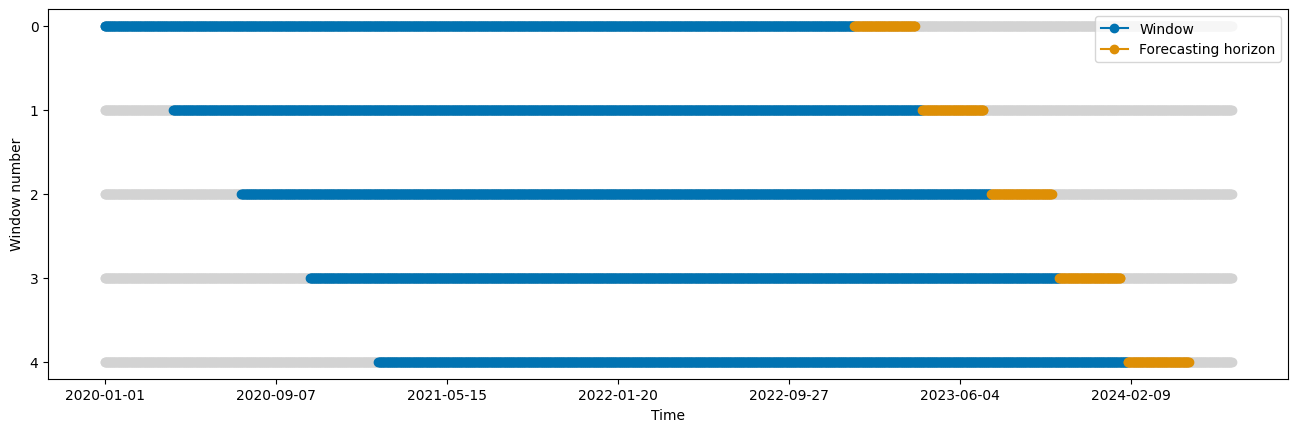

In [8]:
from sktime.utils.plotting import plot_windows

from sktime.split import SlidingWindowSplitter

sliding_window_cv = SlidingWindowSplitter(
    window_length=365 * 3, step_length=100, fh=list(range(1, 90 + 1))
)
plot_windows(cv=sliding_window_cv, y=y_train)
plt.show()

* **Expanding window**: a janela de treino começa com um tamanho mínimo, e vai aumentando ao longo do tempo, incluindo todos os dados anteriores. A cada passo, o modelo é re-treinado com todos os dados disponíveis até aquele ponto.


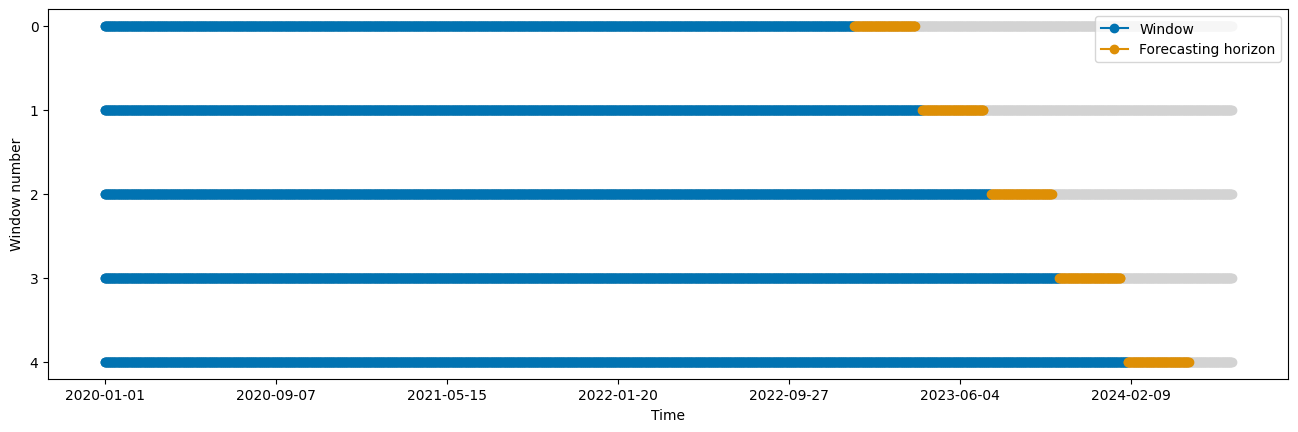

In [9]:
from sktime.split import ExpandingWindowSplitter



expanding_window_cv = ExpandingWindowSplitter(
    initial_window=365 * 3, step_length=100, fh=list(range(1, 90 + 1))
)
plot_windows(cv=expanding_window_cv, y=y_train)
plt.show()

::: .{callout-tip}

Qual escolher? Bom, escolha o que mais representa o que você espera ver em produção.

:::


## Executando o cross-validation

Para executar cross-validation, usamos a função `evaluate`, que recebe o modelo, o esquema de cross-validation, os dados, e a métrica a ser usada.

In [10]:
from sktime.forecasting.model_evaluation import evaluate
from sktime.performance_metrics.forecasting import MeanAbsoluteScaledError
from sktime.forecasting.naive import NaiveForecaster

model = NaiveForecaster(strategy="last")

evaluate(
    forecaster=model,
    cv=expanding_window_cv,
    y=y_train,
    X=None, # Veremos na próxima seçao!
    scoring=MeanAbsoluteScaledError(),
    error_score="raise",
    return_data=True,
)

,test_MeanAbsoluteScaledError,fit_time,pred_time,len_train_window,cutoff,y_train,y_test,y_pred
0,12.839683,0.002775,0.007933,1095,2022-12-30,sales date 2020-01-01...,sales date 2022-12-31...,sales 2022-12-31 458.0 2023-01-01...
1,3.813045,0.002680,0.006148,1195,2023-04-09,sales date 2020-01-01...,sales date 2023-04-10...,sales 2023-04-10 866.0 2023-04-11...
2,8.068216,0.002591,0.006612,1295,2023-07-18,sales date 2020-01-01...,sales date 2023-07-19...,sales 2023-07-19 748.0 2023-07-20...
3,7.854970,0.002779,0.005778,1395,2023-10-26,sales date 2020-01-01...,sales date 2023-10-27...,sales 2023-10-27 1229.0 2023-10-...
4,5.955709,0.002442,0.005910,1495,2024-02-03,sales date 2020-01-01...,sales date 2024-02-04...,sales 2024-02-04 1916.0 2024-02-...
